
# N170 Decoding

This example runs a set of machine learning algorithms on the N170 faces/houses 
dataset, and compares them in terms of classification performance. 

The data used is exactly the same as in the N170 `load_and_visualize` example. 


## Setup



In [1]:
# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.decoding import Vectorizer

# EEG-Notebooks functions
from eegnb.analysis.analysis_utils import load_data
from eegnb.datasets import fetch_dataset

# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

## One subject, One session

### Load Data






In [ ]:
current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(current_dir, '..'))
eegnb_data_path = os.path.join(base_dir, 'data')
n170_data_path = os.path.join(eegnb_data_path, 'visual-N170', 'eegnb_examples')

# If dataset hasn't been downloaded yet, download it 
if not os.path.isdir(n170_data_path):
    fetch_dataset(data_dir=eegnb_data_path, experiment='visual-N170', site='eegnb_examples')        

subject = 1
session = 1
raw = load_data(subject,session,
                experiment='visual-N170', site='eegnb_examples', device_name='muse2016',
                data_dir = eegnb_data_path)

raw.filter(1,30, method='iir')

# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw)
event_id = {'House': 1, 'Face': 2}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True,
                verbose=False, picks=[0,1,2,3])

print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs



Loading these files: 

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.30.01.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.32.50.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.35.26.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.40.17.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.42.33.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-N170\eegnb_examples

<Epochs | 1127 events (all good), -0.102 – 0.801 s (baseline off), ~8.0 MiB, data loaded,
 'House': 565
 'Face': 562>

### Run Classification



In [3]:
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + TS Tuned'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression(C=0.1, class_weight='balanced'))
clfs['ERPCov + TS + Ridge'] = make_pipeline(
    ERPCovariances(estimator='oas'),
    TangentSpace(),
    RidgeClassifierCV(alphas=[0.1,1,10], scoring='roc_auc', cv=3)
)
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + TS tuned 1'] = make_pipeline(
    XdawnCovariances(estimator='lwf', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.1, class_weight='balanced')
)
clfs['XdawnCov + TS tuned 2'] = make_pipeline(
    XdawnCovariances(estimator='lwf', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.05, class_weight='balanced')
)
clfs['XdawnCov + TS tuned 3'] = make_pipeline(
    XdawnCovariances(estimator='oas', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.1, class_weight='balanced')
)
clfs['XdawnCov + TS tuned 4'] = make_pipeline(
    XdawnCovariances(estimator='oas', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.05, class_weight='balanced')
)
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                                    random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Vect + LR
Vect + RegLDA
ERPCov + TS
ERPCov + TS Tuned
ERPCov + TS + Ridge
ERPCov + MDM
XdawnCov + TS
XdawnCov + TS tuned 1
XdawnCov + TS tuned 2
XdawnCov + TS tuned 3
XdawnCov + TS tuned 4
XdawnCov + MDM


In [4]:
# Create DataFrame
results_auc = pd.DataFrame({'AUC': auc, 'Method': methods})

# Function to print summary with max possible AUC
def print_summary_with_max(df, metric_name):
    print(f"\n{metric_name} summary:")
    summary = df.groupby('Method')[metric_name].agg(['mean','std']).round(3)
    # Add max possible column (mean + std, capped at 1)
    summary['max'] = (summary['mean'] + summary['std']).clip(upper=1.0)
    print(summary)

# Print summary
print_summary_with_max(results_auc, 'AUC')


AUC summary:
                        mean    std    max
Method                                    
ERPCov + MDM           0.689  0.018  0.707
ERPCov + TS            0.704  0.030  0.734
ERPCov + TS + Ridge    0.687  0.033  0.720
ERPCov + TS Tuned      0.721  0.029  0.750
Vect + LR              0.645  0.023  0.668
Vect + RegLDA          0.665  0.023  0.688
XdawnCov + MDM         0.661  0.023  0.684
XdawnCov + TS          0.708  0.029  0.737
XdawnCov + TS tuned 1  0.723  0.028  0.751
XdawnCov + TS tuned 2  0.724  0.028  0.752
XdawnCov + TS tuned 3  0.724  0.028  0.752
XdawnCov + TS tuned 4  0.723  0.027  0.750


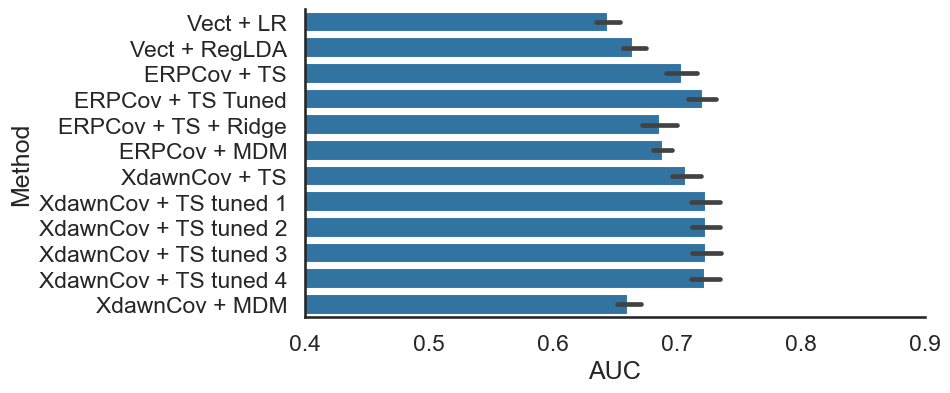

In [5]:
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

fig = plt.figure(figsize=(8, 4))
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 0.9)
sns.despine()

## All subjects, All sessions

### Load Data

In [ ]:
from mne import concatenate_epochs

current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(current_dir, '..'))
eegnb_data_path = os.path.join(base_dir, 'data')
n170_data_path = os.path.join(eegnb_data_path, 'visual-N170', 'eegnb_examples')

# Download dataset if missing
if not os.path.isdir(n170_data_path):
    fetch_dataset(data_dir=eegnb_data_path, experiment='visual-N170', site='eegnb_examples')

# Subject → available session mapping
sub_sess = {
    1: [1],
    2: [1],
    3: [1, 2, 3],
    10: [1, 2, 3],
    11: [1]
}

event_id = {'House': 1, 'Face': 2}
all_epochs = []

# Load only listed subjects/sessions
for subj, sessions in sub_sess.items():
    for sess in sessions:
        try:
            print(f"Loading Subject {subj}, Session {sess}...")
            raw = load_data(
                subj, sess,
                experiment='visual-N170',
                site='eegnb_examples',
                device_name='muse2016',
                data_dir=eegnb_data_path
            )
            raw.filter(1,30, method='iir')
            events = find_events(raw)
            temp_epochs = Epochs(
                raw, events=events, event_id=event_id,
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True,
                verbose=False, picks=[0, 1, 2, 3]
            )
            all_epochs.append(temp_epochs)
            print(f"Loaded Subject {subj}, Session {sess} — {len(temp_epochs)} epochs")

        except Exception as e:
            print(f"Skipping Subject {subj}, Session {sess}: {e}")

# Concatenate all loaded epochs
if all_epochs:
    all_epochs = concatenate_epochs(all_epochs)
    print(f"\nTotal combined epochs: {len(temp_epochs)} from {len(all_epochs)} sessions.")
else:
    raise RuntimeError("No valid epochs found — check subject/session availability.")


Loading Subject 1, Session 1...


Loading these files: 

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.30.01.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.32.50.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.35.26.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.40.17.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.42.33.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb

### Run Classification

In [7]:
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + TS Tuned'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression(C=0.1, class_weight='balanced'))
clfs['ERPCov + TS + Ridge'] = make_pipeline(
    ERPCovariances(estimator='oas'),
    TangentSpace(),
    RidgeClassifierCV(alphas=[0.1,1,10], scoring='roc_auc', cv=3)
)
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + TS tuned 1'] = make_pipeline(
    XdawnCovariances(estimator='lwf', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.1, class_weight='balanced')
)
clfs['XdawnCov + TS tuned 2'] = make_pipeline(
    XdawnCovariances(estimator='lwf', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.05, class_weight='balanced')
)
clfs['XdawnCov + TS tuned 3'] = make_pipeline(
    XdawnCovariances(estimator='oas', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.1, class_weight='balanced')
)
clfs['XdawnCov + TS tuned 4'] = make_pipeline(
    XdawnCovariances(estimator='oas', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.05, class_weight='balanced')
)
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# format data
all_epochs.pick_types(eeg=True)
X = all_epochs.get_data() * 1e6
times = all_epochs.times
y = all_epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                                    random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Vect + LR
Vect + RegLDA
ERPCov + TS
ERPCov + TS Tuned
ERPCov + TS + Ridge
ERPCov + MDM
XdawnCov + TS
XdawnCov + TS tuned 1
XdawnCov + TS tuned 2
XdawnCov + TS tuned 3
XdawnCov + TS tuned 4
XdawnCov + MDM


In [8]:
# Create DataFrame
results_auc = pd.DataFrame({'AUC': auc, 'Method': methods})

# Function to print summary with max possible AUC
def print_summary_with_max(df, metric_name):
    print(f"\n{metric_name} summary:")
    summary = df.groupby('Method')[metric_name].agg(['mean','std']).round(3)
    # Add max possible column (mean + std, capped at 1)
    summary['max'] = (summary['mean'] + summary['std']).clip(upper=1.0)
    print(summary)

# Print summary
print_summary_with_max(results_auc, 'AUC')


AUC summary:
                        mean    std    max
Method                                    
ERPCov + MDM           0.544  0.029  0.573
ERPCov + TS            0.587  0.018  0.605
ERPCov + TS + Ridge    0.584  0.017  0.601
ERPCov + TS Tuned      0.590  0.015  0.605
Vect + LR              0.562  0.020  0.582
Vect + RegLDA          0.573  0.018  0.591
XdawnCov + MDM         0.532  0.029  0.561
XdawnCov + TS          0.587  0.017  0.604
XdawnCov + TS tuned 1  0.587  0.015  0.602
XdawnCov + TS tuned 2  0.583  0.014  0.597
XdawnCov + TS tuned 3  0.589  0.013  0.602
XdawnCov + TS tuned 4  0.586  0.012  0.598


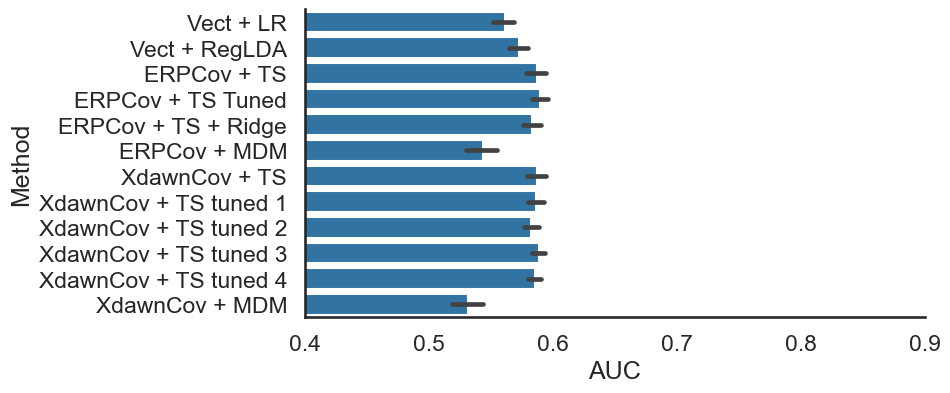

In [9]:
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

fig = plt.figure(figsize=(8, 4))
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 0.9)
sns.despine()